In [8]:
from envSetup import load_tag_pos
from AprilLib import TagDetect
import cv2
import numpy as np

# img_index = 209

intrinsic = np.array(([207.9138,0,315.9991],[0,206.5876,242.7096],[0,0,1]),dtype=np.double)

distortion = np.array([0.2345,-0.1114,0,0],dtype=np.double)

tag_poses, centers, screens = load_tag_pos()
tg = TagDetect(tag_poses, intrinsic, distortion)

In [53]:
Classes = ['bailianhua',
 'chuju',
 'hehua',
 'juhua',
 'lamei',
 'lanhua',
 'meiguihua',
 'shuixianhua',
 'taohua',
 'yinghua',
 'yuanweihua',
 'zijinghua']

In [7]:
import os
import shutil
for c in Classes:
    for root, dirs, files in os.walk(f"../data/train_data_raw/{c}"):
        i = 0
        for file in files:
            shutil.copy2(f"../data/train_data_raw/{c}/{file}", f"./data/train/{c}/{i}.jpg")
            i+=1
    

In [9]:
import cv2
def preprocess_image(filePath: str):
    img = cv2.imread(filePath)
    res = tg.detect(img)
    for tag in res:
        if tag.tag_id == 32:
            _, rvec, tvec = cv2.solvePnP(tg.tagStandard[str(tag.tag_id)], tag.corners, tg.intrinsic, tg.distortion)
            R, _ = cv2.Rodrigues(rvec)
            point2d, _ = cv2.projectPoints(screens[tag.tag_id], R, tvec, intrinsic, distortion)
            pts1 = point2d.astype(np.float32)
            pts2 = np.array([[0, 0], [27, 0], [27, 27], [0, 27]], dtype=np.float32)
            M = cv2.getPerspectiveTransform(pts1, pts2)
            result = cv2.warpPerspective(img, M, (28, 28))
            cv2.imwrite(filePath, result)
        else:
            continue

In [10]:
for root, dirs, files in os.walk("./data/train/"):
    for file in files:
        file_path = os.path.join(root, file)
        preprocess_image(file_path)

In [3]:

import os
import cv2
for root, dirs, files in os.walk("./data/train/bailianhua/"):
    l = []
    for file in files:
        file_path = os.path.join(root, file)
        img = cv2.imread(file_path)
        l.append(img)

In [11]:
import numpy as np
s = np.mean(l, axis=0).astype(int)

In [63]:
import numpy as np
def add_noise(image, mean, std_dev):
    noisy_image = np.array(image.copy())
    noise = np.clip(np.random.normal(mean, std_dev, noisy_image.size), -10, 10)
    noisy_image = noisy_image + noise.reshape(noisy_image.shape).astype('int8')
    noisy_image = np.clip(noisy_image, 0, 255)
    return noisy_image.astype(np.uint8)

In [88]:
from PIL import Image, ImageOps

def shift_image_black(image, shift_x, shift_y):
    # 创建一个新的图像并填充为黑色
    translated_image = Image.new(image.mode, image.size, (0, 0, 0))
    # 计算平移后的位置
    new_x = shift_x
    new_y = shift_y
    # 将原始图像粘贴到新图像中
    translated_image.paste(image, (new_x, new_y))
    return translated_image

def shift_image_white(image, shift_x, shift_y):
    # 创建一个新的图像并填充为黑色
    translated_image = Image.new(image.mode, image.size, (255, 255, 255))
    # 计算平移后的位置
    new_x = shift_x
    new_y = shift_y
    # 将原始图像粘贴到新图像中
    translated_image.paste(image, (new_x, new_y))
    return translated_image

import math

def rotate_image(image, angle):
    # 将角度转换为弧度
    angle_rad = math.radians(angle)
    # 计算旋转后的图像尺寸
    width, height = image.size
    new_width = 28
    new_height = 28
    # 创建一个新的图像并填充为黑色
    rotated_image = Image.new(image.mode, (new_width, new_height), (255, 255, 255))
    # 计算旋转后的位置
    dx = -2
    dy = -3
    # 将原始图像旋转并粘贴到新图像中
    rotated_image.paste(image.rotate(angle, expand=True), (dx, dy))
    return rotated_image

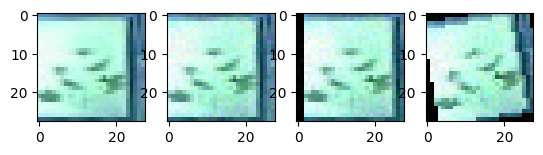

In [89]:
import matplotlib.pyplot as plt
from PIL import Image
s = Image.open("./data/train/bailianhua/8.jpg")
s2 = add_noise(s, 0, 10)
s3 = shift_image_black(s, 2, 0)
s3 = add_noise(s3, 0, 10)
s4 = rotate_image(s, 10)
s4 = add_noise(s4, 0, 10)
plt.subplot(1,4,1)
plt.imshow(s)
plt.subplot(1,4,2)
plt.imshow(s2)
plt.subplot(1,4,3)
plt.imshow(s3)
plt.subplot(1,4,4)
plt.imshow(s4)
plt.show()

In [90]:
import random
import cv2
import os
random.seed(2023)
for c in Classes:
    for root, dirs, files in os.walk(f"./data/train/{c}"):
        imglist = []
        for file in files:
            base = Image.open(f"./data/train/{c}/{file}")
            xs1 = shift_image_black(base, 3, 0)
            xs1 = add_noise(xs1, 0, 5)
            imglist.append(xs1)

            xs2 = shift_image_black(base, -3, 0)
            xs2 = add_noise(xs2, 0, 5)
            imglist.append(xs2)

            xs3 = shift_image_black(base, 0, 3)
            xs3 = add_noise(xs3, 0, 5)
            imglist.append(xs3)

            xs4 = shift_image_black(base, 0, -3)
            xs4 = add_noise(xs4, 0, 5)
            imglist.append(xs4)

            xs5 = shift_image_white(base, 3, 0)
            xs5 = add_noise(xs5, 0, 5)
            imglist.append(xs5)

            xs6 = shift_image_white(base, -3, 0)
            xs6 = add_noise(xs6, 0, 5)
            imglist.append(xs6)

            xs7 = shift_image_white(base, 0, 3)
            xs7 = add_noise(xs7, 0, 5)
            imglist.append(xs7)

            xs8 = shift_image_white(base, 0, -3)
            xs8 = add_noise(xs8, 0, 5)
            imglist.append(xs8)

            xs9 = add_noise(base, 0, 10)
            imglist.append(xs9)

            xs10 = rotate_image(s, 10)
            xs10 = add_noise(xs10, 0, 5)
            imglist.append(xs10)

        random.shuffle(imglist)
        if not os.path.exists(f"./data/enhanced_train/{c}"):
            os.mkdir(f"./data/enhanced_train/{c}")
        for ii, gg in enumerate(imglist):
            gg_bgr = cv2.cvtColor(gg, cv2.COLOR_RGB2BGR)
            cv2.imwrite(f"./data/enhanced_train/{c}/{ii}.jpg", gg_bgr)

error: OpenCV(4.8.1) :-1: error: (-5:Bad argument) in function 'cvtColor'
> Overload resolution failed:
>  - src is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'src'
